In [83]:
from analysis.utils import module_reload
module_reload('analysis')
from analysis.import_data import import_true_reco
from analysis.calc import get_kinematics
from analysis.plot_matplotlib import plot_hist, export_figures
from analysis.transfer import plot_transfer
from analysis.fit_funcs import fit_funcs, fit_inits
import seaborn as sns
import numpy as np
import json

In [68]:
df = import_true_reco()
zhh = df[df['is_zhh'] == 1]
zzh = df[df['is_zzh'] == 1]
data = {
    'zhh': zhh,
    'zzh': zzh
}

repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/compare_truejet_matchingreco.root_zhh_zzh.npy


In [76]:
rho = {
    'zhh': [],
    'zzh': []
}

for key in data:
    df = data[key]
    transfer_data_true = []
    
    for i in range(1, 5):
        transfer_data_true.append(np.sqrt(df[f"jet{i}_px"]**2 + df[f"jet{i}_py"]**2 + df[f"jet{i}_pz"]**2))
    
    rho[key] = np.array(transfer_data_true).flatten()

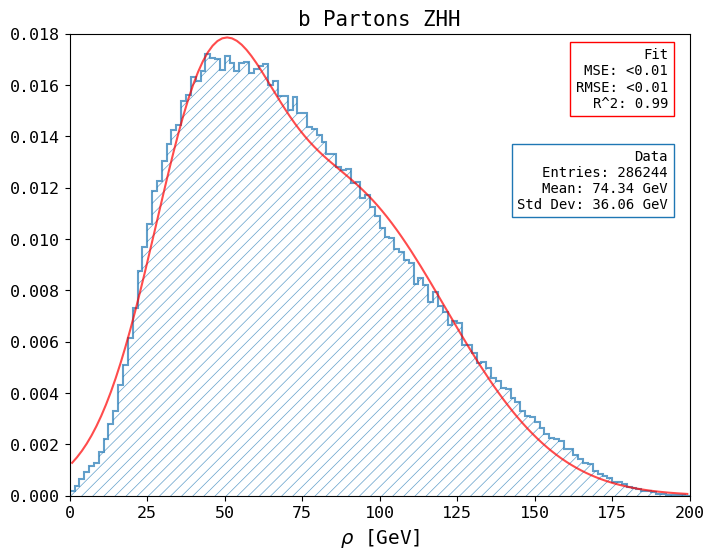

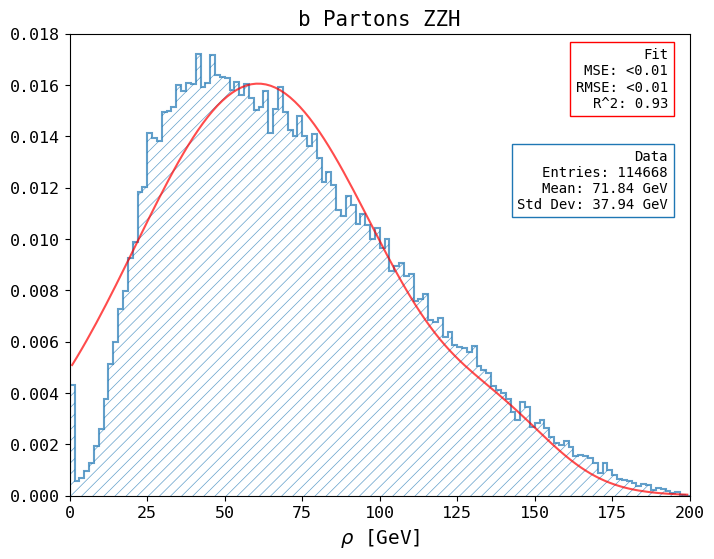

In [91]:
from scipy.optimize import curve_fit
from math import pi, sqrt, exp, log

figures = []
fit = 'dbgauss_old'
for key in ['zhh', 'zzh']:
    dt = rho[key]
    fit_func = fit_funcs[fit]
    fit_init = fit_inits(dt)[fit]

    y, bins = np.histogram(dt, bins=128, density=True, range=(0, 200))
    x = (bins[:-1] + bins[1:]) / 2

    popt, pcov = curve_fit(fit_func, x, y, p0=fit_init, maxfev = 300000)

    hist_args = { 'fit_func': (lambda x: fit_func(x, *popt)), 'normalize': True,
                'unitx': r'GeV',
                'xlim': (0,200), 'xlim_binning': (0, 200), 'ylim': (0., 0.018),
                'yscale': 'linear', 'xlabel': r'$\rho$ [GeV]',
                'title': f'b Partons {key.upper()}'
                }
    
    figures.append(plot_hist(dt, **hist_args))

export_figures(f'{repo_dir}/notebooks/results/7_parton_rho_prior.pdf', figures)
with open(f'{repo_dir}/notebooks/results/7_parton_rho_prior_fitparams.txt', 'w', encoding='utf-8') as file:
    json.dump(popt.tolist(), file, ensure_ascii=False, indent=4)